In [1]:
import tensorflow as tf

http://cs231n.github.io/convolutional-networks/

In [2]:
tf.__version__

'1.10.0'

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from six.moves import cPickle as pickle
from  PIL import Image
import numpy as np

In [17]:
from os.path import isfile, isdir
#from tqdm import tqdm
import tarfile

data_file = "C:\\Nitin\\studies and notes\\tensor-flow\\CIFAR\\"

if isdir(data_file):
    with tarfile.open(data_file+'cifar-10-python.tar.gz') as tar:
        tar.extractall()
        print("sucess")
        tar.close()

sucess


In [18]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
#preprocessing-1
cifar_path = "cifar-10-batches-py"
def cifar_batch(cifar_path, batch_id):
    with open(cifar_path+"/data_batch_"+str(batch_id), mode = "rb") as file:
        batch = pickle.load(file, encoding='Latin-1')
        
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']
    return(features,labels)
    
    
    

In [37]:
#checking content of the cifar dataset
def check_cifar(data_dir, batch_id,sample_id):
    features,labels = cifar_batch(data_dir,batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None
    
    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key], value))
        
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](airplane) : 994
Label Counts of [1](automobile) : 1042
Label Counts of [2](bird) : 965
Label Counts of [3](cat) : 997
Label Counts of [4](deer) : 990
Label Counts of [5](dog) : 1029
Label Counts of [6](frog) : 978
Label Counts of [7](horse) : 1015
Label Counts of [8](ship) : 961
Label Counts of [9](truck) : 1029

Example of Image 300:
Image - Min Value: 0 Max Value: 251
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


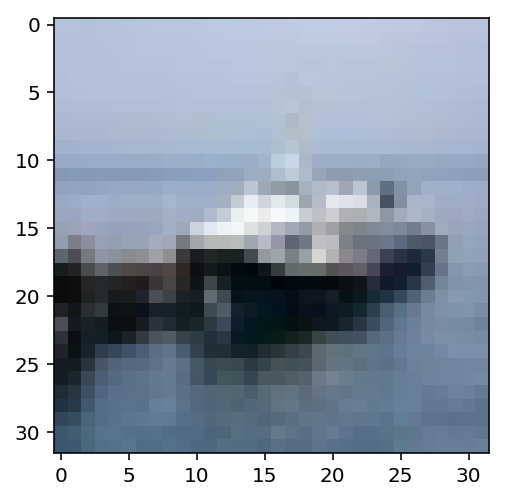

In [38]:
%matplotlib inline

cifar_path = "cifar-10-batches-py"
import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 300
check_cifar(cifar_path, batch_id, sample_id)

In [40]:
#normalization of the pixel values will help in avoiding exploding gradient since if we are using relu as an activation function 
#the gradient coming from back propagation canturn out to be huge given the pixel values(0-255) so normalise to 0-1

def normalize_vals(x):
    min_val = np.min(x)
    max_val = np.max(x)
    return((x - min_val)/(max_val-min_val))

In [45]:
# one hot encoding for labels (10)

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
        function
            - encode elements into OHC representation
    """
    
    encoded = np.zeros((len(x),10)) #10 classes only
    
    for i, v in enumerate(x):
        encoded[i,v] = 1
    return(encoded)

In [46]:
one_hot_encode((1,3,4))

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [51]:
# preprocessing and normalizing 
def preprocess_and_save(normalize_vals,one_hot_encode,features, labels, filename ):
    """
        argument
            - normalize, one hot encoding, features, labels filename
        return
            - None
        function
            - normalise, encode labels and save pickle dumps
    """
    features = normalize_vals(features)
    labels = one_hot_encode(labels)
    pickle.dump((features,labels), open(filename,'wb'))
    
    
def preprocess_and_save_data(cifar_path, normalize_vals, one_hot_encode):
    """
        argument
            - normalize, one hot encoding, features,cifar_path
        return
            - None
        function
            - normalise, encode data and save pickle dumps use preprocess and save function
    """
    
    batches = 5
    valid_features = []
    valid_labels = []
    
    for i in range(1, batches+1):
        features, labels = cifar_batch(cifar_path,i)
        
        #locating index for validation set
        idx_val = int(len(features)*0.1)
        #calling preprocess and save functions for todos
        preprocess_and_save(normalize_vals,one_hot_encode,features[:-idx_val], labels[:-idx_val],
                            'preprocess_batch_' + str(i) + '.p')
        
        
        #validation set added together
        valid_features.extend(features[-idx_val:])
        valid_labels.extend(labels[-idx_val:])
        
        
        preprocess_and_save(normalize_vals,one_hot_encode,np.array(valid_features),
                            np.array(valid_labels), 'preprocess_validation.p')
        with open(cifar_path + '/test_batch', mode = 'rb') as file:
            batch = pickle.load(file, encoding='Latin-1')
            
        #preprocessing test features by reshape and transform
        test_features = batch['data'].reshape((len(batch['data']), 3,32,32)).transpose(0,2,3,1)
        test_labels = batch['labels']
        
        preprocess_and_save(normalize_vals, one_hot_encode, np.array(test_features), np.array(test_labels),
                            'preprocess_training.p')
        
    
    

In [52]:
preprocess_and_save_data(cifar_path,normalize_vals,one_hot_encode)

In [53]:
#loading data from dumped pickle
import pickle
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [54]:
tf.reset_default_graph()


In [56]:
x = tf.placeholder(tf.float32,shape = (None, 32,32,3), name = 'input_X')
y = tf.placeholder(tf.float32, shape = (None,10), name = 'label_y')

keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

In [60]:
#defining conv net with model parameters
#import pkg_resources
#from pkg_resources import DistributionNotFound, VersionConflict
#dependencies = ['tensorflow>=1.10.0']
#pkg_resources.require(dependencies)

In [68]:
def conv_net(X, keep_prob):
    #defining variable on convolutional filter/kernel from a truncated(clipped end) normal distribution sizes actual size = 3*3*3 
    conv1_filter = tf.Variable(tf.truncated_normal(shape = [3,3,3,64],mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape = [3,3,64,128],mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape = [5,5,128,256],mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape = [5,5,256,512],mean=0, stddev=0.08))
    
    conv1 = tf.nn.conv2d(X, conv1_filter, strides = [1,1,1,1], padding ='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')  #data format NHWC(batch h*w*c)
    conv1_final = tf.layers.batch_normalization(conv1_pool)
    
    conv2 = tf.nn.conv2d(conv1_final, conv2_filter, strides = [1,1,1,1], padding ='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')  #data format NHWC(batch h*w*c)
    conv2_final = tf.layers.batch_normalization(conv2_pool)
    
    conv3 = tf.nn.conv2d(conv2_final, conv3_filter, strides = [1,1,1,1], padding ='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')  #data format NHWC(batch h*w*c)
    conv3_final = tf.layers.batch_normalization(conv3_pool)
    
    conv4 = tf.nn.conv2d(conv3_final, conv4_filter, strides = [1,1,1,1], padding ='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')  #data format NHWC(batch h*w*c)
    conv4_final = tf.layers.batch_normalization(conv4_pool)
    
    #flatten before FNN
    conv_flat = tf.contrib.layers.flatten(inputs= conv4_final)
    
    #Fully Connected Neural Network
    full1 = tf.contrib.layers.fully_connected(inputs=conv_flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)
    
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)
    
    output = tf.contrib.layers.fully_connected(inputs = full4, num_outputs=10, activation_fn = None)
    
    return output
    
    
    
    
    
    
    

In [69]:
#Hyperparameters
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [71]:
#training
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name ='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits,labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#model accuracy
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [72]:
# optimization

def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [73]:

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [74]:

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [75]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2483 Validation Accuracy: 0.154000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.9736 Validation Accuracy: 0.152800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7137 Validation Accuracy: 0.256400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.7418 Validation Accuracy: 0.278000
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5943 Validation Accuracy: 0.277800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.7651 Validation Accuracy: 0.278800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.6891 Validation Accuracy: 0.237400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.5481 Validation Accuracy: 0.300000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.4896 Validation Accuracy: 0.341400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.4729 Validation Accuracy: 0.322600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.2574 Validation Accuracy: 0.478200
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.1497 Validation Accuracy: 0.453400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.9249 Validation Accuracy: 0.548400


In [76]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.09384952229299363



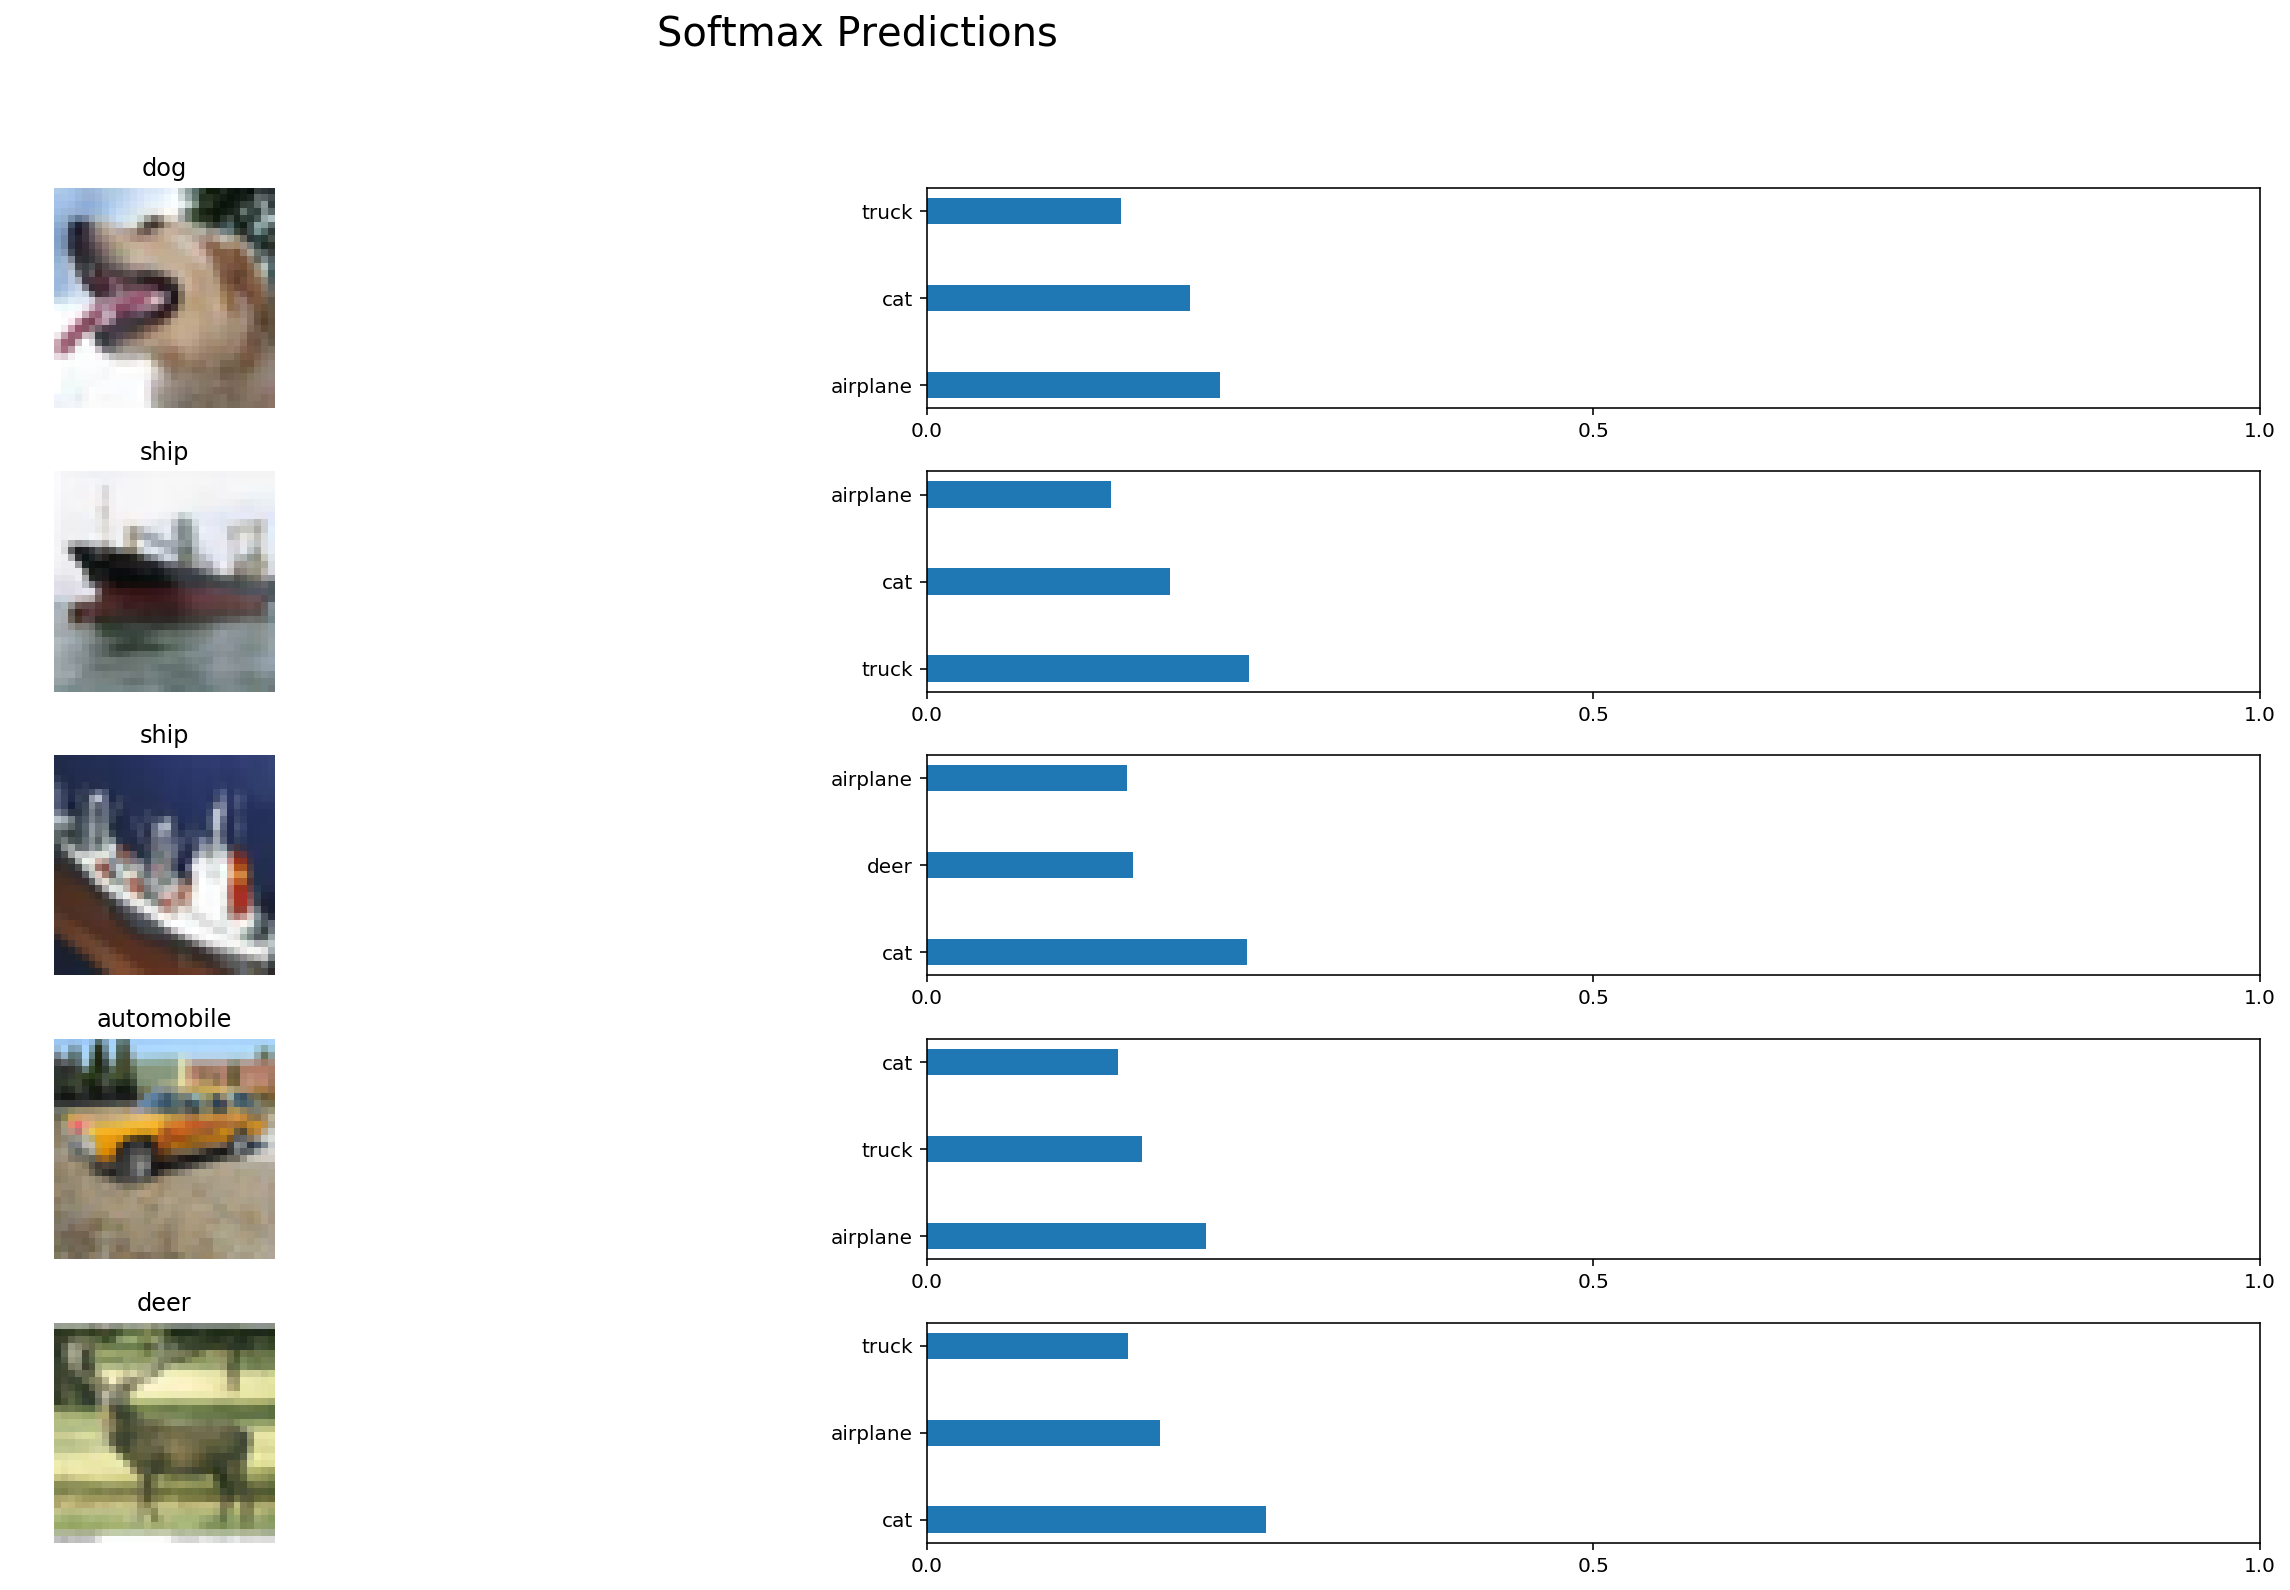

In [80]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_X:0')
        loaded_y = loaded_graph.get_tensor_by_name('label_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()
